# DEEP LEARNING MODEL for PREDICTING QUANTITATIVE PHENOTYPES from SIMULATED GENOMIC DATA

*by Víctor Fernández Oliveras*

## 1. Introduction

This **Jupyter Notebook** is a **supplementary material** for the theoretical manuscript **Deep Learning and its Application to Predicting Quantitative Phenotypes from Genomic Data** (bachelor thesis), available in the same [GitHub repository](https://github.com/victor-fdz/Deep-learning-for-predicting-quantitative-phenotypes-from-genotypes). Here, the theoretical information discussed can be **put into practice**, functioning as a **teaching material** or as an **introduction to the usage of deep learning** models to quantitative phenotypic predictions. 

Below, you will find a simple example of a **deep learning model** capable of **predicting** the value of a fictitious quantitative trait associated with simulated **genomic data**. Data used here can be understood as **consecutive sequeces** or as **sets of genomic positions**. 

### 1.1 Glossary

All the necessary theory is explained in the manuscript. However, here you will find a list of concepts that are essential to understand this example. 
- **Encoding step**: data is binary encoded in tensors (multidimensional matrices, matrices of matrices) in order to make them readable for the model.
- **Data splitting step**: the dataset is divided into a **training set** (used in the training step) and a **test set** (used in the testing step).
- **Training**: iterative process in which the model "learns" from data and updates its parameters to minimize the error between its predictions and the input.
- **Overfitting**: when the model "learns" too much from data overadapting its predictions to the training set.
- **Hyperparameters**: elements of the network that are explicitly defined by the modeller rather than “leart” by the model during training (*e.g.*, layers and activation functions).
- **Loss**: error metric. In this case, as the value to be predicted is continuous, the mean squared error is used.
- **Testing**: evaluation of the model's generalization performance with non previously seen data.
- **Interpretability**: methods that aim to understand how the model performs its predictions. 

### 1.2 Import necessary packages

All these packages are defined in the **.yaml file** available in the repository and that **must be load as an environment in conda**. It is important to import all modules at the beggining of the process to:
- avoid reloading them each time a chunk is run.
- notice possible problems with the versions of the packages.

In [1]:
# Artificial intelligence modules
    # sklearn: data pre-processing & performance metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
    # keras/tensorflow: architecture and interpretabilty of the model 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential # General model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten # Layers
from tensorflow.keras.optimizers import Adam # Optimizer
from tensorflow.keras.callbacks import EarlyStopping # Early stopping function 

# Data manipulating and visualization
import numpy as np # Arrays
import pandas as pd # Tables (Dataframes)
import matplotlib.pyplot as plt # Data visualization
from matplotlib.colors import Normalize # Normalization
from matplotlib.cm import ScalarMappable 
plt.style.use('bmh') # Common style for all plots
import logomaker # To represent importance scores

# Other modules
import random # Randomizer
import ipywidgets as widgets # Interactive chunks
from IPython.display import display # To show tables

## 2. Dataset generation

### 2.1 Dataset personalization

With the objective of offering a more personalized experience, you are encouraged to decide:
- Custom name for the phenotype (`Phen. name`).
- Level of environmental effect in the trait (`Env. effect`).
- Length of the sequences (`Seq. length`).
- Number of sequences in the dataset (`Num. seqs.`).

**Tip**: model performance increases with less environmental effect (the model only learns from genomic data) and more sequences (it has more information to learn from).

In [33]:
# Define the widgets
phenotype_name = widgets.Text(value='MyPhenotype', description='Phen. name:')
environment = widgets.FloatSlider(min=2, max=4, description="Env. effect:")
length_sequences = widgets.IntSlider(min=200, max=350, step=50, description="Seq. length:")
number_sequences = widgets.IntSlider(min=8000, max=10000, step=1000, description="Num. seqs.:")

# Display them to the user
display(phenotype_name, environment, length_sequences, number_sequences)

Text(value='MyPhenotype', description='Phen. name:')

FloatSlider(value=2.0, description='Env. effect:', max=4.0, min=2.0)

IntSlider(value=200, description='Seq. length:', max=350, min=200, step=50)

IntSlider(value=8000, description='Num. seqs.:', max=10000, min=8000, step=1000)

In [49]:
# Check the values
env_effect = environment.value
phen_name = phenotype_name.value
len_seq = length_sequences.value
n_seqs = number_sequences.value
print("Phenotype name:", phen_name)
print("Environmental effect:", env_effect)
print("Sequence length:", len_seq)
print("Number of sequences:", n_seqs)

Phenotype name: MyPhenotype
Environmental effect: 2.0
Sequence length: 200
Number of sequences: 9000


### 2.2 Reference sequence

In [50]:
# Create a random initial/reference sequence
ref = []
for i in range(len_seq):
    ref.append(random.choice(["A", "C", "T", "G"])) # Random nucleotide at each position
ref_seq = "".join(ref)

# Show the sequence and its length
print(f"Reference sequence (length = {len_seq}bp):")
print(50*"-")
print(ref_seq)

Reference sequence (length = 200bp):
--------------------------------------------------
TTATTTATCCAGAGCGCCACCGGGGATGATAAGGTGTAATGATGCCTGGAGCACGGAGAAAGGGATCCCGTTGCCTGGGCAGATAGGTAGGAAGTAACCTTGCGTTGTTCTCGGTGCGTTTCCGATAACGGTGACCCCGAATTTTACATATAAACAATCGTATATTCTTTGTGAGCGATCAAGTAGCCTGGGCCACAGGG


### 2.3 Number of variants, positions and effects

In [51]:
# Decide a random number of positions with phenotypic effect, between 10 and 25
n_pos = random.randrange(10,25)

# Decide which loci will have phenotypic effec
indexes = sorted(random.sample(range(0,len_seq),n_pos))

# Generate a dictionary of dictionaries with the effect of each nucleotide in each position
pos_phen = {}
for i in range (0,n_pos): # For each locus
    # Decide a random effect for each nucleotide
    effect = {
    "A": random.uniform(-4,+4),
    "C": random.uniform(-4,+4),
    "T": random.uniform(-4,+4),
    "G": random.uniform(-4,+4),
    }
    # Create the entry of the position in the dictionary
    pos_phen[indexes[i]] = effect

In [52]:
# Randomly decide which variants will be involved in epistatic relations
epi = sorted(random.sample(list(pos_phen.keys()),9)) # Fixed number (arbitrary) of epistatic loci
coefs = [] # Epistatic coefficients
for i in range(4): # Fixed number (arbitrary) of epistatic relations
    coefs.append(random.uniform(-1.5,+1.5)) # Random coefficients

# Show the coefficients
coef_epi = ", ".join([str(round(n,3)) for n in coefs])
print("Coefficients of the epistasic relations:", coef_epi)

Coefficients of the epistasic relations: 0.786, 1.282, 0.491, 0.324


In [53]:
# Show the structure of the dictionary that has the loci with phenotypic effect 
print("Loci, Effect of each nucleotide")
print(50*"-")
pairs = list(pos_phen.items())
for pair in pairs[:3]: # Show only first 3 entries
    print(pair)
print("...")

Loci, Effect of each nucleotide
--------------------------------------------------
(52, {'A': -1.9708769744130947, 'C': 3.779837310105381, 'T': 2.5745942737736556, 'G': -3.961165403188213})
(61, {'A': 3.90272550732712, 'C': 1.334324489110628, 'T': -0.0037249075068359616, 'G': -0.652607283657054})
(71, {'A': -2.437953331359779, 'C': -3.672033160852437, 'T': -2.6091657311758976, 'G': 2.3090014342143714})
...


In [54]:
# To sum up, show the nucleotidic positions and if they are involved in epistatic relations. 
col_epist = []
for i in indexes: # For each position
    if i in epi:
        col_epist.append("Yes")
    else: 
        col_epist.append("No")
table_epi = pd.DataFrame({"Loci index":indexes,"Epistasis":col_epist}, index = range(1,len(indexes)+1))
table_epi

,Loci index,Epistasis
1,52,No
2,61,Yes
3,71,Yes
4,74,Yes
5,88,Yes
6,92,No
7,108,Yes
8,112,Yes
9,120,No
10,122,Yes


### 2.4 Mutated sequences and phenotype calculation

In [55]:
# Function to calculate the phenotype for each sequence
def phen_calc(DNA, # Sequence
             n_pos, # Number of positions with phenotypic effect
             pos_phen, # Dictionary with phenotypic effect information
             epi, # Epistatic positions
             coefs):  # Coefficients for epistasis
    
    # Calculate the effect of each position on the sequence
    additive_effects = 0
    for i in range (0,len(DNA)):
        if i in pos_phen.keys():
            nt = DNA[i]
            additive_effects += pos_phen.get(i).get(nt)

    # Define the positions and coefficients implicated in epistasis with more visual names
    pos1 = epi[0]
    pos2 = epi[1]
    pos3 = epi[2]
    pos4 = epi[3]
    pos5 = epi[4]
    pos6 = epi[5]
    pos7 = epi[6]
    pos8 = epi[7]
    pos9 = epi[8]
    coef1 = coefs[0]
    coef2 = coefs[1]
    coef3 = coefs[2]
    coef4 = coefs[3]

    # Calculate the epistasis
    # Acess to the key with the locus position and select the nt presented by the sequence in that position to obtain the effect
    effect1 = coef1*pos_phen[pos1][DNA[pos1]]*pos_phen[pos2][DNA[pos2]] 
    effect2 = coef2*pos_phen[pos3][DNA[pos3]]*pos_phen[pos4][DNA[pos4]]
    effect3 = coef3*pos_phen[pos5][DNA[pos5]]/pos_phen[pos6][DNA[pos6]]
    effect4 = coef4*pos_phen[pos7][DNA[pos7]]*pos_phen[pos8][DNA[pos8]]*pos_phen[pos9][DNA[pos9]] # 3 genes interacting in this epistatic relation
    epistasis =  effect1 + effect2 + effect3 + effect4

    # Select a random environmental effect (considering the value decided by the user)
    env = random.uniform(-env_effect,env_effect)

    # Calculate and return the phenotype 
    phen = additive_effects + epistasis + env
    return phen

In [56]:
# Induce mutations to create the dataset
seqs = []
for i in range(n_seqs): # In each sequence of the dataset
    mutated_seq = ref_seq
    max_n_variants = int(round(len_seq*0.1,0)) # 10% of the length of the sequence
    for n in range(random.randrange(max_n_variants+1)): # Decide a random number of variants
        if random.uniform(0.0,1.0)>0.55: # More likely in important sites
            pos = random.choice(indexes)
        else:
            pos = random.randrange(len(mutated_seq))
        # Introduce the variant in the sequence,
        nts = ["A", "C", "T", "G"]
        del(nts[nts.index(mutated_seq[pos])]) # To not consider as an option the nucleotide is already in the position
        mutated_seq = mutated_seq[:pos] + random.choice(nts) + mutated_seq[pos + 1:]
    # After all variants introduced, append the mutated sequence to the list
    seqs.append(mutated_seq)
    
# Calculate the phenotype for every sequence
phens = [phen_calc(seq,n_pos,pos_phen,epi,coefs) for seq in seqs]

# Define it all as a dataframe
df = pd.DataFrame({
    "sequences": seqs,
    "phenotypes": phens})

# Save the dataframe as a CSV file and display it to see its format
df.to_csv("sequences_data.csv", index=False)
df

,sequences,phenotypes
0,TTATTTATCCAGAGCGCCACCGGGGATGATAAGGTGTAATGATGCC...,9.780642
1,TTATTAAGCCGGAGCGCCACCGGGGATGATAAGGTGTAGTGATGCC...,-11.850975
2,TTAATAATCCAGAACGCCACCGGGGATGATAAGGTGTAATGATGCC...,-11.104516
3,TTATTTATCCAGAGCGCCACCGGGGATGATAAGGTGTAATGATGCC...,5.483347
4,TTATTTATCCAGAGCGCCACCGGGGCTGATAAGGTGTAATGATGCC...,-1.592760
...,...,...
8995,TTATTTATCCAGAGCGCCACCGGGGATGCTAAGGTGTAATGATGCC...,-8.633362
8996,TTATTTATCCAGAGCGCCACCGGGGATGATAAGGTGTAATGATGCC...,2.172046
8997,TTATTTATCCAGAGCGCCACCGGGGATGATAAGGTGTAATGATGCC...,6.108217
8998,TTATTTATCCAGAGCGCCACCGGGGATGATAAGGTGTAATGATGCC...,-7.606659


## 3. Data pre-processing

### 3.1 Normalization

In [57]:
# Read the dataframe and define a list for the sequences and another for their phenotypes
df = pd.read_csv('sequences_data.csv')
seqs = list(df["sequences"])
phens = list(df["phenotypes"])

# Apply the normalization method (standarization)
m = df["phenotypes"].mean()
s = np.sqrt(df["phenotypes"].var())
norm_phens = [((p-m)/s) for p in phens] # Normalization of each phenotype
phens = norm_phens

### 3.2 Encoding

In [58]:
# Define some functions as objects. This will avoid future errors
integer_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(categories='auto')

# Encode sequences first with integer encoding and then with one-hot encoding
input_seqs = []
for seq in seqs:
  integer_encoded1 = integer_encoder.fit_transform(list(seq)) # Generates a vector where each element is a nucleotide and each nt has a number between 0 and 3 assigned (e.g. A=0,C=1,T=2,G=3)
  integer_encoded2 = np.array(integer_encoded1).reshape(-1, 1) # Transpose the vector
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded2) # Binary conversion to an incidence matrix for each of the 4 nucleotides
  input_seqs.append(one_hot_encoded.toarray()) # Binary sequence defined as a matrix of 0s and 1s

input_seqs = np.stack(input_seqs) # Join all the matrices into a tensor

# Define the phenotypes as a reshaped matrix (transposed)
phens = np.array(phens).reshape(-1, 1)
# Phenotypes do not need to be binary encoded due to they are already numbers

In [59]:
# Let's see an example of some of these intermediate steps
print("Not encoded sequence (string):\n\n" + seq)
print("\n" + 50*"-" + "\n")
print("Encoded sequence (vector):\n\n" + str(integer_encoded1))
print("\n" + 50*"-" + "\n")
print("Binary encoded sequence (matrix):\n\n" + str(one_hot_encoded.toarray()))
print("\n" + 50*"-" + "\n")
print("Sequences merged into a tensor:\n\n" + str(input_seqs))

Not encoded sequence (string):

TTATTTATCCAGAGCGCCACCGGGGATGATAAGCTGTAATGATGCCTGGAGCACGGAGAAACGGATCCCGTTGCCTGGGCAGATAGGTAGGAAGTAACCTTGCGTTGTCCTCCGTGCGTTTCCGAGAACGGTGACCCCGAATTTTACATATAAACGATCGTATATTCTTTGTGAGCGATCAAGTAGCCTGGGCCACAGGG

--------------------------------------------------

Encoded sequence (vector):

[3 3 0 3 3 3 0 3 1 1 0 2 0 2 1 2 1 1 0 1 1 2 2 2 2 0 3 2 0 3 0 0 2 1 3 2 3
 0 0 3 2 0 3 2 1 1 3 2 2 0 2 1 0 1 2 2 0 2 0 0 0 1 2 2 0 3 1 1 1 2 3 3 2 1
 1 3 2 2 2 1 0 2 0 3 0 2 2 3 0 2 2 0 0 2 3 0 0 1 1 3 3 2 1 2 3 3 2 3 1 1 3
 1 1 2 3 2 1 2 3 3 3 1 1 2 0 2 0 0 1 2 2 3 2 0 1 1 1 1 2 0 0 3 3 3 3 0 1 0
 3 0 3 0 0 0 1 2 0 3 1 2 3 0 3 0 3 3 1 3 3 3 2 3 2 0 2 1 2 0 3 1 0 0 2 3 0
 2 1 1 3 2 2 2 1 1 0 1 0 2 2 2]

--------------------------------------------------

Binary encoded sequence (matrix):

[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 

### 3.3 Data splitting

In [60]:
# Split the dataset into training and testing subsets
train_seqs, test_seqs, train_phens, test_phens = train_test_split(
    input_seqs, # Encoded sequences
    phens, # Normalized phenotypes
    test_size = 0.25, # Proportion of sequences kept for the test step
    random_state = 42) # Defining a random state permits fixing a certain shuffling of the data before splitting
                    # Set to None if you want a different random splitting each time, but that will considerably reduce the reproducibility of the model

### 3.4 Phenotype distribution

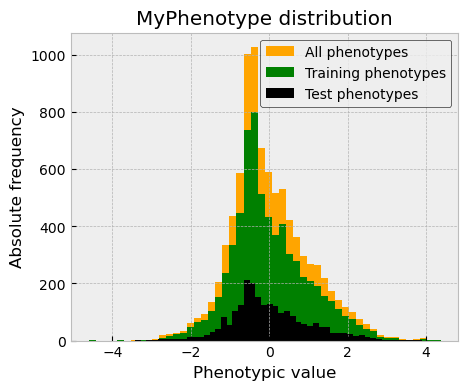

In [61]:
# Plot the distribution of the phenotype values in the diverse groups (all, training and test) with a histogram
# It must be observed a similar distribution in all groups
fig, ax = plt.subplots(figsize=(5,4)) 
ax.hist(phens,bins=50,color="orange",label="All phenotypes")
plt.hist(train_phens,bins=50,color="green",label="Training phenotypes")
plt.hist(test_phens,bins=50,color="black",label="Test phenotypes")
plt.legend(edgecolor = "black")
ax.set_title(f"{phen_name} distribution")
ax.set_xlabel("Phenotypic value")
ax.set_ylabel("Absolute frequency")
plt.show()

**Improvement**: Other preprocessing steps (*e.g.,* downsampling)  should be considered here in order to reduce distributional differences (for example, low representation of extreme values). *See the manuscript for more*.

## 4. Model hyperparameters setting 

These hyperparameters were set after several manual tries with different combinations.

**Improvement**: An automated machine learning (AutoML) method could be applied here using keras_tuner so a better hyperparameters combination could be found.

In [62]:
# General model construction
model = Sequential()

# Convolutional layers
model.add(Conv1D(filters = 256, # Filters = number of neurons
                 kernel_size = 3, # Kernel = number of nucleotides analyzed for each step in each neuron.
                 input_shape = (len_seq, 4))) # Shape = (sequence_length, one-hot encoding depth -> 4 nt options)
model.add(MaxPooling1D(pool_size = 4))
model.add(Flatten())

# Fully Connected Layers
model.add(Dense(32, # Number of neurons
                activation = 'relu')) # Actvation function
model.add(Dropout(rate=0.05)) # Dropout (avoid overfitting)
model.add(Dense(8,activation = 'softplus'))
model.add(Dense(32,activation = 'relu'))

# "Decision" layer
model.add(Dense(1,activation = "linear"))

# Define the objective function to optimize and the optimization method
model.compile(loss = 'mean_squared_error', # Loss function
              optimizer = "adam") # Typical optimizer

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 198, 256)          3328      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 49, 256)          0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 12544)             0         
                                                                 
 dense_4 (Dense)             (None, 32)                401440    
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 8)                 264       
                                                      

## 5. Model training

In [63]:
# Function that stops the training when the loss starts growing -> avoid overfitting. 
early_stopping = EarlyStopping(
    monitor = 'val_loss', # The interrogated value is the validation loss
    patience = 10, # Number of epochs to wait without improvement before stopping the training
    restore_best_weights = True) # The model reverts to the weights from the epoch with the best performance

**Attention!** The training process may take a few minutes to be completed. 

In [64]:
# Train the model
trained_model = model.fit(
    train_seqs, # Training sequences
    train_phens, # Associated phenotypes
    epochs = 50, # Max number of epochs
    validation_split = 0.35, # Proportion of the training set used for the validation
    callbacks = [early_stopping], # Previously defined early stopping method
    verbose = 0) # Defines which information is displayed. Not important

# Convert the ssummary of the training process into a dataframe
history_df = pd.DataFrame.from_dict(trained_model.history)

In [65]:
# Function to show the Loss metric in the trainig and validation subsets
def display_history(data):
    print("Model's history:")
    print(30*'-')
    display(data[:].style.highlight_min(color='lime')) # Display the table, with the minimum values highlighted.

# Apply the function to show the history
display_history(history_df)

Model's history:
------------------------------


,loss,val_loss
0,0.857402,0.428799
1,0.305665,0.255680
2,0.223819,0.221676
3,0.198992,0.268526
4,0.183368,0.201320
5,0.172518,0.216007
6,0.153071,0.172002
7,0.142271,0.289145
8,0.137067,0.161875
9,0.118864,0.150511


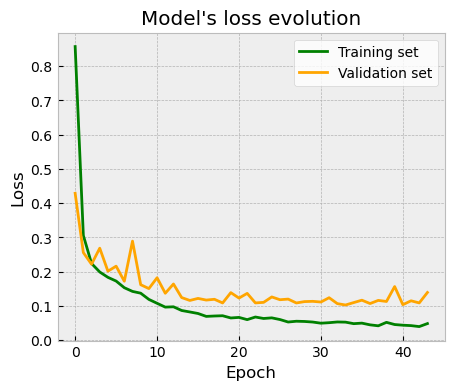

In [66]:
# Function to plot the metrics. Alternatively, use TensorBoard for more detailed analysis. 
def plot_metric(data, metric):

  fig, ax = plt.subplots(figsize=(5,4))
  
  # Data
  plt.plot(data[metric],color = "green") 
  plt.plot(data['val_{}'.format(metric)], color = "orange")
  # Title, labels and legend
  ax.set_title("Model's loss evolution")
  ax.set_ylabel("Loss")
  ax.set_xlabel('Epoch')
  ax.legend(['Training set', 'Validation set'],facecolor="white",loc="best")
  plt.style.use('bmh')
  plt.show()

# Apply the function to show the plot
plot_metric(history_df, "loss")

## 6. Model testing

### 6.1 Defining useful functions

In [67]:
# Function that converts predictions into a dataframe with: real phenotype, predicted phenotype and error.
def preds_summary(predictions):
  real_phens = [p[0] for p in test_phens]
  pred_phens = [p[0] for p in predictions]
  # Difference between real and predicted phenotypes:
  error = [(real_phens[i] - pred_phens[i]) for i in range(len(real_phens))]
  df = pd.DataFrame({"Real Phenotypes":real_phens,"Predicted Phenotypes":pred_phens,"Error":error},index=np.arange(1, len(real_phens)+1))
  return df, error

In [68]:
# Function that plots the correlation between predicted and real phenotypes; and the error distribution
def plot_all(phens_real, # Real phenotypes
             phens_pred, # Predicted phenotypes
             r2, mse, # R squared (coefficient of determination) and mean squared error
             error): # Errors

    fig, ax = plt.subplots(1,2,figsize=(12,4)) 
    
    # Error distribution
    counts, bins, patches = ax[0].hist(error,bins=30)
    err = [abs(val.xy[0]) for val in patches] # Define the error of each bin
    norm = Normalize(vmin=min(err), vmax=max(err)) # Normalize bin heights for color mapping
    cmap = plt.get_cmap('summer')  # Select a color map (color gradient)
    for err, patch in zip(err, patches): # Apply gradient to each bar
        color = cmap(norm(err)) # Define the color mappint the error value to the color gradient
        patch.set_facecolor(color) # Assign it to the rectange
    # Define titles and axis
    ax[0].set_title("Error distribution",fontsize = 11)
    ax[0].set_xlabel("Error value")
    ax[0].set_ylabel("Absolute frequency")
    plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=ax[0], label="|Error|") # Legend for the color gradient
    
    # Correlation scatter plot with R^2 and MSE 
    scat = ax[1].scatter(phens_real, phens_pred, c=[abs(e) for e in error], cmap=cmap)
    ax[1].set_title("Real phenotyes VS Model's predictions")
    ax[1].set_xlabel("Input phenotypic value")
    ax[1].set_ylabel("Predicted phenotypic value")
    ax[1].text(0.05, 0.95,f"R^2 = {round(r2,4)}\nLoss (MSE) = {round(mse,5)}", transform=plt.gca().transAxes, ha='left',va='top', #Text alignment
               bbox=dict(facecolor='white', alpha=0.7, edgecolor='black')) # Text box
    # Show both plots
    plt.show()

### 6.2 Test set prediction

71/71 [==============================] - 1s 7ms/step


,Real Phenotypes,Predicted Phenotypes,Error
1,0.256391,0.253993,0.002398
2,-0.008692,0.051571,-0.060264
3,1.465287,0.903590,0.561697
4,0.207295,0.171953,0.035342
5,-0.296336,-0.322658,0.026322
...,...,...,...
2246,-0.894423,-0.659054,-0.235368
2247,0.511770,0.521392,-0.009622
2248,0.464930,0.067088,0.397842
2249,-0.185895,-0.028524,-0.157371


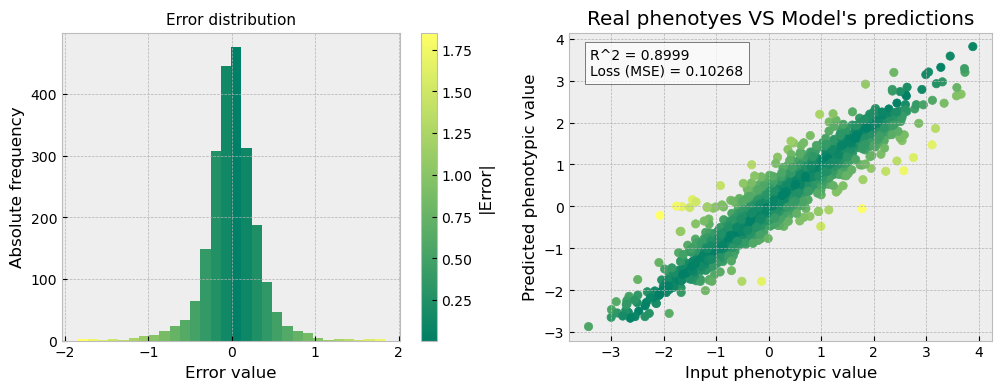

In [70]:
# Use the model to predict phenotypes in the test subset 
raw_preds = model.predict(test_seqs)

# Display a summary table with the real phenotypes, the associated prediction and the prediction error 
table, error = preds_summary(raw_preds)
display(table)

# Calculate the metrics and plot the graphs
mse = mean_squared_error(list(table["Real Phenotypes"]), list(table["Predicted Phenotypes"]))
r2 = r2_score(list(table["Real Phenotypes"]), list(table["Predicted Phenotypes"]))
plot_all(list(table["Real Phenotypes"]), list(table["Predicted Phenotypes"]),r2,mse,error)

Note that: 
- The Loss value for the test set should be similar to the loss value for the validation set seen in *5. Model training*. Otherwise, the model is not capable of generalizing.
- The higher the R^2, the better the model prediction capacity.
- The error should follow a normal distribution.

**Improvement**: There exist performance determination methods that consider distributional differences in the data.

## 7. Interpretability

In [71]:
# Function to calculate the importance score for each position in the sequences
def importance_scores(model, input_sequence, target_output=None):
  
    # Make sure that the input is a set of one example
    input_sequence = np.expand_dims(input_sequence, axis=0)  # Shape: (1, sequence_length, 4)
    # Convert the sequence to a tensor for gradient computation
    input_tensor = tf.convert_to_tensor(input_sequence, dtype=tf.float32) # Shape: (1, sequence_length, 4)

    # Use the model to predict the phenotype in the given sequence
    with tf.GradientTape() as grad_tape:
        grad_tape.watch(input_tensor)
        prediction = model(input_tensor)
    
    gradients = grad_tape.gradient(prediction, input_tensor) # Compute the gradient of the loss with respect to the input
    position_scores = tf.reduce_mean(tf.abs(gradients), axis=-1).numpy() # Reduce gradients across the one-hot encoding axis (sum or mean can be used)
    position_scores = np.squeeze(position_scores, axis=0) # Squeeze the set dimension

    return position_scores

# Function to calculate the mean importance score for each position considering all sequences
def mean_scores(model, train_seqs):
    total_scores = None
    n_seqs = len(train_seqs)

    # Compute the importance scores for each sequence
    for seq in train_seqs:
        pos_scores = importance_scores(model, seq)
        # Initialize the "total_scores" array if it is the first sequence
        if total_scores is None:
            total_scores = np.zeros_like(pos_scores) # Generate a 0s vector with the shape of the position vector for the first sequence
        total_scores += pos_scores # # Add the current sequence's scores to the total vector  

    # Compute the mean calculation and output it
    scores_mean = total_scores / n_seqs 
    return scores_mean

# Apply the function
scores = mean_scores(model, train_seqs)

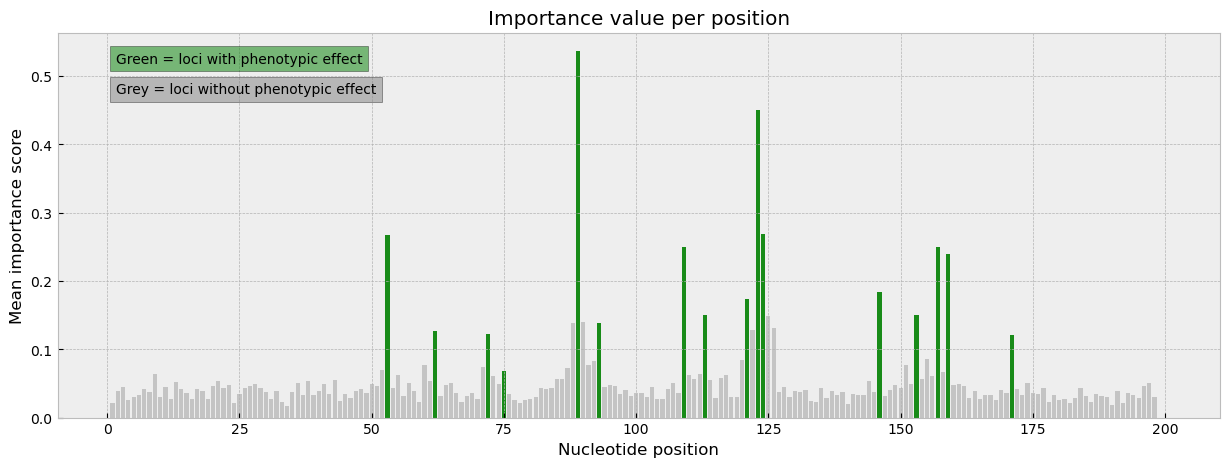

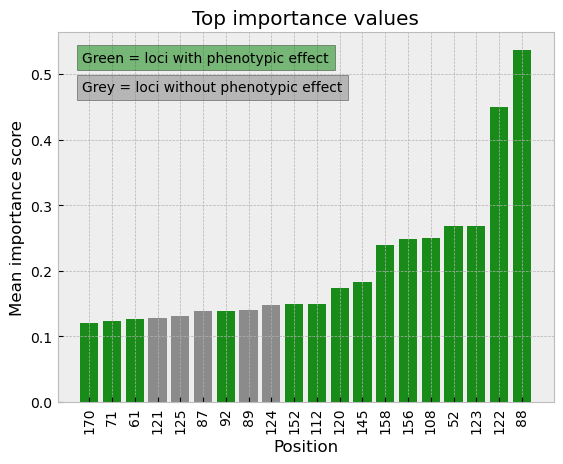

In [75]:
# Function to plot importance scores
def interpretability(vector):
  key_positions = indexes  # Phenotypic important nucleotides
  colors = ['silver' if i not in key_positions else 'green' for i in range(len(vector))] # positions with effect in green
  
  # Define the plot  
  fig, ax = plt.subplots(figsize=(15,5))
  ax.bar(range(1,len(vector)+1), vector, color=colors, alpha=0.9)  

  # Set axis labels, title and text (legend)
  ax.set_xlabel("Nucleotide position")
  ax.set_ylabel("Mean importance score")
  ax.set_title("Importance value per position")
  ax.text(0.05, 0.95, "Green = loci with phenotypic effect",transform=plt.gca().transAxes, ha='left', va='top', # Text alignment
               bbox=dict(facecolor='green', alpha=0.5, edgecolor='black')) # Text box 
  ax.text(0.05, 0.87, "Grey = loci without phenotypic effect",transform=plt.gca().transAxes, ha='left', va='top', 
               bbox=dict(facecolor='grey', alpha=0.5, edgecolor='black')) 
  
  # Show the graph
  plt.show()
    
# Function to plot importance scores for those positions with higher scores
def interpretability_top(matrix):
  top_pos = np.argsort(matrix)[-20:]  # Top 20 positions
  colors = ['grey' if i not in indexes else 'green' for i in top_pos] # positions with effect in green

  # Define the plot
  fig, ax = plt.subplots()
  ax.bar(range(len(top_pos)), matrix[top_pos], color=colors,alpha=0.9)
  
  # Set ticks, axis labels, title and legend
  ax.set_xticks(range(len(top_pos)), top_pos, rotation=90)
  ax.set_xlabel("Position")
  ax.set_ylabel("Mean importance score")
  ax.set_title("Top importance values")
  ax.text(0.05, 0.95, "Green = loci with phenotypic effect",transform=plt.gca().transAxes, ha='left', va='top',
               bbox=dict(facecolor='green', alpha=0.5, edgecolor='black')) 
  ax.text(0.05, 0.87, "Grey = loci without phenotypic effect",transform=plt.gca().transAxes, ha='left', va='top', 
               bbox=dict(facecolor='grey', alpha=0.5, edgecolor='black')) 
    
  # Show the graph
  plt.show()
  return top_pos
    
interpretability(scores)
top = interpretability_top(scores)

We can see how most of the genomic positions with higher contribution to the prediction-making have a real phenotypic effect. This shows that the model is "learning" important positions. 

<Figure size 640x480 with 0 Axes>

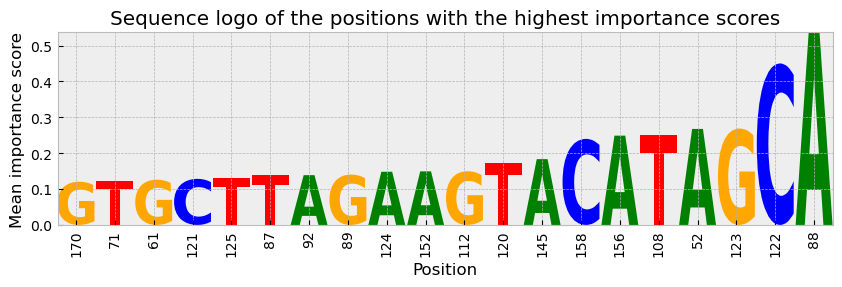

In [79]:
# Function to plot sequence logo of the 20 most important positions
def logo_plot(ref_seq, scores):
    
    # Construct the matrix
    data = []
    for i in top:
        vec = [0,0,0,0] # Initial vector with 0 importance in each nucleotide
        if ref[i] == "A": # The importance value do not consider the relative importance of each nucleotide of the position
                          # Use the reference sequence to determine which nucleotide is plotted in each position
            vec[0] += scores[i] # Nucleotide height is the position score
        elif ref[i] == "C":
            vec[1] += scores[i]
        elif ref[i] == "T":
            vec[2] += scores[i]
        else: 
            vec[3] += scores[i]
        data.append(vec)

    # Figure plotting
    plt.figure()
    logo = logomaker.Logo(pd.DataFrame(data, columns = ["A", "C", "T", "G"])) # Generate the sequence logo
    
    # Axis and title
    plt.xlabel("Position")
    plt.ylabel("Mean importance score")
    plt.title("Sequence logo of the positions with the highest importance scores")
    plt.xticks(
        range(len(top)),  
        top, # Define xticks as the indexes of these important positions
        rotation=90)    

# Apply the function
logo_plot(ref, scores)

## 8. Model saving

Finally, you can easly save and reload your trained model by using the following code:

In [82]:
path_to_store  = 'model_saved.keras' # Define where and models' name
model.save(path_to_store) # Save it
loaded_model = keras.models.load_model(path_to_store) # Reload it whenever you want

In [Netron](https://netron.app/) you can upload your model and get a schematic of its architecture. 

## 9. References

Some structures, functions and plots are inspired from those available in: 

1. Pérez-Enciso, M., & Zingaretti, L. M. (2019). A Guide on Deep Learning for Complex Trait Genomic Prediction. Genes, 10(7), 553. https://doi.org/10.3390/genes10070553

2. Zou, J., Huss, M., Abid, A., Mohammadi, P., Torkamani, A., & Telenti, A. (2019). A primer on deep learning in genomics. Nature Genetics, 51(1), 12–18. https://doi.org/10.1038/s41588-018-0295-5

This example was constructed using Keras documentation, examples, etc:

3. Chollet, F. and others (2015). Keras. Retrieved from https://keras.io